In [ ]:
# projeto atp players 

In [ ]:
# passo 1 do crisp dm já feito 
# vamos para a analise de dados (passo 2)

In [1]:
# importar as bibliotecas 

import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings('ignore')

In [2]:
# ler a base de dados 

atp = pd.read_json("atpplayers.json", lines = True)

In [3]:
# pegar somente os torneios na india 

india1 = atp.loc[(atp["Location"].str.split(',', expand = True)[1].str.strip() == "India")]
india2 = atp.loc[atp["Location"].str.strip() == "India"]
india = pd.concat([india1, india2])

In [4]:
# dropando colunas aparentemente inuteis

india.drop(columns = ["_id", "LinkPlayer", "Location"], inplace = True)

In [5]:
# substituindo string para valores nulos

india.replace(['NA', 'null', '-', ''], value=np.nan, inplace=True)

In [6]:
# separando coluna "hand"

india[['Forehand', 'Backhand']] = india['Hand'].str.split(', ', expand=True)
india = india.drop(columns=['Hand'])

In [7]:
# separando coluna da Data do torneio

india[['Data_inicio', 'Data_final']] = india['Date'].str.split(' - ', expand=True)
india = india.drop(columns=['Date'])

In [8]:
india['Data_inicio'] = pd.to_datetime(india['Data_inicio'])
india['Data_final'] = pd.to_datetime(india['Data_final'])

In [9]:
india['Duração'] = (india['Data_final'] - india['Data_inicio']).dt.days

In [10]:
# alteracao na coluna Duracao feita depois do modelo

india.groupby("Duração").count()
india.drop(india[india["Duração"] == 7].index)

,PlayerName,Born,Height,Tournament,Ground,Prize,GameRound,GameRank,Oponent,WL,Score,Forehand,Backhand,Data_inicio,Data_final,Duração
1763,Daniil Medvedev,"Moscow, Russia",198.0,Chennai,Hard,"$447,480",Finals,14.0,Roberto Bautista Agut,L,36 46,Right-Handed,Two-Handed Backhand,2017-01-02,2017-01-08,6.0
1764,Daniil Medvedev,"Moscow, Russia",198.0,Chennai,Hard,"$447,480",Semi-Finals,96.0,Dudi Sela,W,"46 76, 62",Right-Handed,Two-Handed Backhand,2017-01-02,2017-01-08,6.0
1765,Daniil Medvedev,"Moscow, Russia",198.0,Chennai,Hard,"$447,480",Quarter-Finals,117.0,Jozef Kovalik,W,61 64,Right-Handed,Two-Handed Backhand,2017-01-02,2017-01-08,6.0
1766,Daniil Medvedev,"Moscow, Russia",198.0,Chennai,Hard,"$447,480",Round of 16,64.0,Yen-Hsun Lu,W,64 63,Right-Handed,Two-Handed Backhand,2017-01-02,2017-01-08,6.0
1768,Daniil Medvedev,"Moscow, Russia",198.0,Chennai,Hard,"$447,480",Round of 32,82.0,Thiago Monteiro,W,63 63,Right-Handed,Two-Handed Backhand,2017-01-02,2017-01-08,6.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1299669,Lucas Renard,"Stockholm, Sweden",185.0,India F8,Hard,"$10,000",Round of 16,549.0,Ranjeet Virali-Murugesan,L,26 36,Right-Handed,Two-Handed Backhand,2011-06-06,2011-06-12,6.0
1299671,Lucas Renard,"Stockholm, Sweden",185.0,India F8,Hard,"$10,000",Round of 32,1768.0,Yannick Nelord,W,63 75,Right-Handed,Two-Handed Backhand,2011-06-06,2011-06-12,6.0
1299672,Lucas Renard,"Stockholm, Sweden",185.0,India F7,Hard,"$10,000",Quarter-Finals,740.0,Vitali Reshetnikov,L,46 06,Right-Handed,Two-Handed Backhand,2011-05-30,2011-06-05,6.0
1299673,Lucas Renard,"Stockholm, Sweden",185.0,India F7,Hard,"$10,000",Round of 16,1447.0,Neeraj Elangovan,W,75 62,Right-Handed,Two-Handed Backhand,2011-05-30,2011-06-05,6.0


In [11]:
# pegar ranks de todos os jogadores

rank = india.drop(['PlayerName', 'Born','Height','Tournament','Ground','Prize','GameRound','Score','Forehand','Backhand','Data_final','Duração','WL'], axis=1)
rank = rank.rename(columns={'Oponent': 'PlayerName'})

In [12]:
india = india.merge(rank[['PlayerName', 'GameRank', 'Data_inicio']], on=['PlayerName', 'Data_inicio'], how='left')

In [13]:
# altura de todos os jogadores

height = india.drop(['Born','Tournament','Ground','Prize','GameRound','Score','Forehand','Backhand','Data_final','Duração','WL', 'GameRank_x','GameRank_y','Oponent','Data_inicio'], axis=1)
height = height.rename(columns={'PlayerName': 'Oponent'})
height = height.drop_duplicates()

In [14]:
india = india.merge(height[['Oponent', 'Height']], on=['Oponent'], how='left')

In [15]:
# forehand dos dois jogadores

forehand = india.drop(['Born','Tournament','Ground','Prize','GameRound','Score','Backhand','Data_final','Duração','WL', 'GameRank_x','GameRank_y','Oponent','Data_inicio', 'Height_x','Height_y'], axis=1)
forehand = forehand.rename(columns={'PlayerName': 'Oponent'})
forehand = forehand.drop_duplicates()

In [16]:
india = india.merge(forehand[['Oponent', 'Forehand']], on=['Oponent'], how='left')

In [17]:
# backhand dos dois jogadores

backhand = india.drop(['Born','Tournament','Ground','Prize','GameRound','Score','Forehand_x','Forehand_y','Data_final','Duração','WL', 'GameRank_x','GameRank_y','Oponent','Data_inicio', 'Height_x','Height_y'], axis=1)
backhand = backhand.rename(columns={'PlayerName': 'Oponent'})
backhand = backhand.drop_duplicates()

In [18]:
india = india.merge(backhand[['Oponent', 'Backhand']], on=['Oponent'], how='left')

In [19]:
# country dos dois jogadores

country = india.drop(['Tournament','Ground','Prize','GameRound','Score','Backhand_x','Backhand_y','Forehand_x','Forehand_y','Data_final','Duração','WL', 'GameRank_x','GameRank_y','Oponent','Data_inicio', 'Height_x','Height_y'], axis=1)
country = country.rename(columns={'PlayerName': 'Oponent'})
country= country.drop_duplicates()

In [20]:
india = india.merge(country[['Oponent', 'Born']], on=['Oponent'], how='left')

In [21]:
# coluna vantagem (criada depois do modelo)

india["vantagem_playername"] = india.apply(lambda row: True if (row['GameRank_x'] - 40 > row['GameRank_y'] and row['Height_x'] - 10 > row['Height_y']) else False, axis=1)
india["vantagem_oponent"] = india.apply(lambda row: True if (row['GameRank_y'] - 40 > row['GameRank_x'] and row['Height_y'] - 10 > row['Height_x']) else False, axis=1)

In [22]:
# verificando se existem vantagem para ambos ao mesmo tempo (pois nao deveria existir)

resultado = india[(india['vantagem_playername'] == True) & (india['vantagem_oponent'] == True)]
resultado

,PlayerName,Born_x,Height_x,Tournament,Ground,Prize,GameRound,GameRank_x,Oponent,WL,...,Data_inicio,Data_final,Duração,GameRank_y,Height_y,Forehand_y,Backhand_y,Born_y,vantagem_playername,vantagem_oponent


In [23]:
india['vantagem'] = india['vantagem_playername'] != india['vantagem_oponent']

In [5]:
# tirando os duplicados

india = india.loc[india["WL"] == "W"]
india.drop("WL", axis=1, inplace=True)
india = india.drop_duplicates()

In [25]:
# contando os sets

india['Sets'] = india['Score'].str.count('\d')

In [26]:
india['Sets'] = india['Sets'].replace(1, 0)
india['Sets'] = india['Sets'].replace(7, 6)
india['Sets'] = india['Sets'].replace(5, 4)
india['Sets'] = india['Sets'].replace(11, 10)
india['Sets'] = india['Sets'].replace(3, 4)

In [27]:
india['Sets'] = india['Sets'] // 2

In [28]:
# remover linhas de 0,1,4 ou 5 sets

mask = india['Sets'].isin([0, 1, 4, 5])
india = india.drop(india[mask].index)

In [29]:
india.drop("Score", axis=1, inplace=True)

In [30]:
# ajustando coluna prize

india['Prize'] = india['Prize'].str.replace('$', '').str.replace(',', '').astype(float)

In [31]:
# ajustar coluna born

def get_country(born):
    try:
        country = born.split(", ")[-1]
    except:
        country = born
    return country

In [32]:
india["Country_PlayerName"] = india["Born_x"].apply(get_country)
india["Country_Oponent"] = india["Born_y"].apply(get_country)

In [33]:
india['Country_PlayerName'].replace('US', 'USA', inplace=True)
india['Country_PlayerName'].replace('U.S.A.', 'USA', inplace=True)
india['Country_PlayerName'].replace('NY', 'USA', inplace=True)
india['Country_Oponent'].replace('US', 'USA', inplace=True)
india['Country_Oponent'].replace('U.S.A.', 'USA', inplace=True)
india['Country_Oponent'].replace('NY', 'USA', inplace=True)

In [34]:
india.drop('Born_x', axis=1, inplace=True)
india.drop('Born_y', axis=1, inplace=True)

In [35]:
## Limpeza de dados

# jogadores de altura nula

mean_height_x = int(india['Height_x'].mean())
india['Height_x'] = india['Height_x'].fillna(mean_height_x)

mean_height_y = int(india['Height_y'].mean())
india['Height_y'] = india['Height_y'].fillna(mean_height_y)

In [36]:
# prize

median_prize = int(india['Prize'].median())
india['Prize'] = india['Prize'].fillna(median_prize)

In [37]:
# paises nulos

india['Country_PlayerName'] = india['Country_PlayerName'].fillna('Unknown')
india['Country_Oponent'] = india['Country_Oponent'].fillna('Unknown')

In [38]:
# game rank

mean_gamerank_x = int(india['GameRank_x'].mean())
india['GameRank_x'] = india['GameRank_x'].fillna(mean_gamerank_x)

mean_gamerank_y = int(india['GameRank_y'].mean())
india['GameRank_y'] = india['GameRank_y'].fillna(mean_gamerank_y)

In [39]:
# hand

# forehand

india['Forehand_x'] = india['Forehand_x'].fillna('Unknown Forehand')
india['Forehand_y'] = india['Forehand_y'].fillna('Unknown Forehand')

# backhand

india['Backhand_x'] = india['Backhand_x'].fillna('Unknown Backhand')
india['Backhand_y'] = india['Backhand_y'].fillna('Unknown Backhand')

In [40]:
# removendo nulos que sobraram na "Data_final"

india.dropna(inplace=True)

In [41]:
# criando coluna da diferença das alturas

india['Height_diff'] = abs(india['Height_x'] - india['Height_y'])

In [42]:
# criando coluna da diferença dos ranks

india['Rank_diff'] = abs(india['GameRank_x'] - india['GameRank_y'])

In [43]:
# criando coluna que indica se pelo menos um dos jogadores é indiano ou nao

india['India'] = ((india['Country_PlayerName'] == "India") | (india['Country_Oponent'] == "India"))

In [44]:
# criando coluna que indica se os jogadores tem a mesma forehand ou nao

india['Same_forehand'] = india['Forehand_x'] == india['Forehand_y']

In [45]:
# criando coluna que indica se os jogadores tem a mesma backhand ou nao

india['Same_backhand'] = india['Backhand_x'] == india['Backhand_y']

In [46]:
# criando coluna que indica se os dois jogadores sao de paises de tradicao ou nao

india['Country_PlayerName'] = np.where(india['Country_PlayerName'].isin(['USA', 'Spain', 'France', 'United Kingdom', 'Russia']), 1, 0)
india['Country_Oponent'] = np.where(india['Country_Oponent'].isin(['USA', 'Spain', 'France', 'United Kingdom', 'Russia']), 1, 0)

In [47]:
india['Same_Country'] = (india['Country_PlayerName'] == india['Country_Oponent'])
india.drop(['Country_PlayerName','Country_Oponent'], axis=1, inplace=True)

In [48]:
# coluna que indica se pode ser um jogo disputado ou nao (depois do modelo)

india['equilibrio'] = india.apply(lambda row: True if (row["Same_Country"]  == True and row["Rank_diff"] <= 40) else False, axis = 1)

In [49]:
# criando um schema para a base de dados 
# ou seja, atribuindo um tipo de dados para cada coluna (variavel)

schema = {"PlayerName": "string",
         "Height_x": "int64",
          "Height_y": "int64",
          "Tournament": "string",
          "Ground": "string",
          "Prize": "int64",
          "GameRound": "string",
          "GameRank_x": "int64",
          "GameRank_y": "int64",
          "Oponent": "string",
          "Forehand_x": "category",
          "Forehand_y": "category",
          "Backhand_x": "category",
          "Backhand_y": "category",
          "Data_inicio": "datetime64[ns]",
          "Data_final": "datetime64[ns]",
          "Duração": "int64",
          "Sets": "category",
          "Same_Country": "category",
          "Rank_diff": "int64",
          "Height_diff":"int64"
         }

In [50]:
india = india.astype(schema)

In [51]:
## Analises

# Sets por GameRank

media_por_set_gamerank = india.groupby('Sets')['Rank_diff'].mean()

Text(0.5, 1.0, 'Sets por Rank_diff')

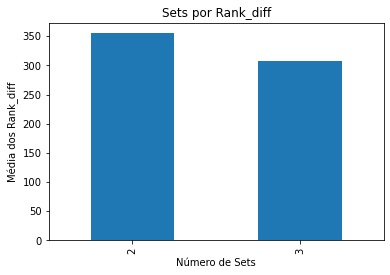

In [52]:
media_por_set_gamerank.plot(x='Sets', y='Rank_diff', kind='bar')
plt.xlabel('Número de Sets')
plt.ylabel('Média dos Rank_diff')
plt.title('Sets por Rank_diff')

In [6]:
india.head()

,PlayerName,Born,Height,Hand,Tournament,Date,Ground,Prize,GameRound,GameRank,Oponent,Score
1764,Daniil Medvedev,"Moscow, Russia",198,"Right-Handed, Two-Handed Backhand",Chennai,2017.01.02 - 2017.01.08,Hard,"$447,480",Semi-Finals,96,Dudi Sela,"46 76, 62"
1765,Daniil Medvedev,"Moscow, Russia",198,"Right-Handed, Two-Handed Backhand",Chennai,2017.01.02 - 2017.01.08,Hard,"$447,480",Quarter-Finals,117,Jozef Kovalik,61 64
1766,Daniil Medvedev,"Moscow, Russia",198,"Right-Handed, Two-Handed Backhand",Chennai,2017.01.02 - 2017.01.08,Hard,"$447,480",Round of 16,64,Yen-Hsun Lu,64 63
1768,Daniil Medvedev,"Moscow, Russia",198,"Right-Handed, Two-Handed Backhand",Chennai,2017.01.02 - 2017.01.08,Hard,"$447,480",Round of 32,82,Thiago Monteiro,63 63
3044,Rafael Nadal,"Manacor, Mallorca, Spain",185,"Left-Handed, Two-Handed Backhand",Chennai,2007.12.31 - 2008.01.06,Hard,"$411,000",Semi-Finals,17,Carlos Moya,"67, 76, 76"


In [53]:
# prizes por edicao

intervalos = [0, 100000, 200000, 300000, 400000, 500000, 600000]
india['Intervalo_Prize'] = pd.cut(india['Prize'], intervalos)

In [7]:
# pegando somente as finais, para ver quantas ediçoes diferentes aconteceram 
# base de dados somente com as finais dos torneios 

finais = india.loc[india["GameRound"] == "Finals"]

In [10]:
finais["GameRound"].value_counts()

Finals    266
Name: GameRound, dtype: int64

In [8]:
finais1 = finais['Intervalo_Prize'].value_counts()

KeyError: 'Intervalo_Prize'

<AxesSubplot:ylabel='Intervalo_Prize'>

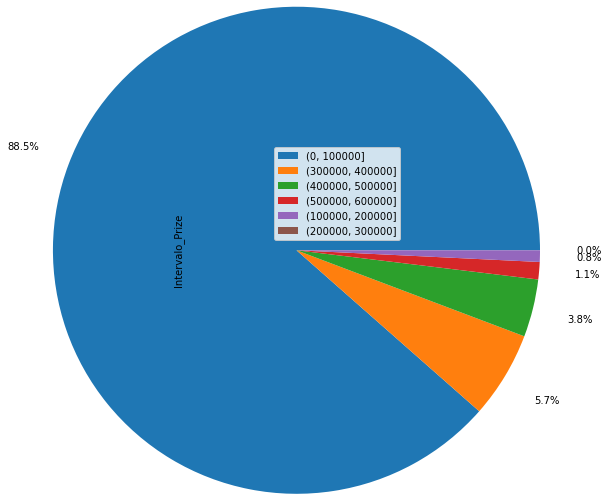

In [56]:
finais1.plot(kind='pie', labels=None, legend=True, autopct='%1.1f%%', pctdistance=1.2, radius=2.8)

In [56]:
cross_tab = pd.crosstab(india['GameRound'], [india['Sets'][india['Sets'].isin([2, 3])]])
cross_tab = cross_tab.drop('Round Robin', axis=0)
cross_tab = cross_tab.reindex(['1st Round Qualifying', '2nd Round Qualifying', '3rd Round Qualifying', 'Round of 64', 'Round of 32', 'Round of 16', 'Quarter-Finals','Semi-Finals','Finals'])

In [57]:
crosstab_pct = cross_tab.apply(lambda r: r/r.sum(), axis=1)
crosstab_pct = crosstab_pct.apply(lambda r: round(r, 2), axis=0)
crosstab_pct

Sets,2,3
GameRound,,
1st Round Qualifying,0.74,0.26
2nd Round Qualifying,0.76,0.24
3rd Round Qualifying,0.68,0.32
Round of 64,0.71,0.29
Round of 32,0.74,0.26
Round of 16,0.71,0.29
Quarter-Finals,0.69,0.31
Semi-Finals,0.66,0.34
Finals,0.70,0.30


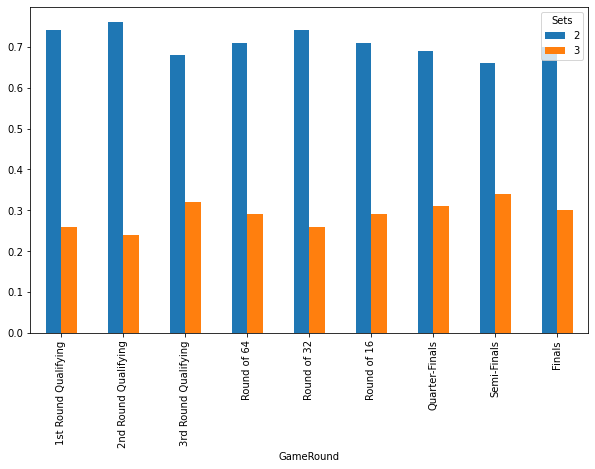

In [58]:
ax = crosstab_pct.plot.bar(figsize=(10,6))

<AxesSubplot:xlabel='Same_forehand'>

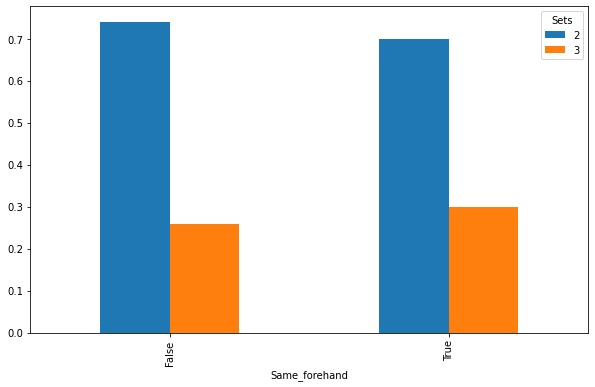

In [60]:
# Same_forehand

cross_tab1 = pd.crosstab(india['Same_forehand'], [india['Sets']])
crosstab_pct1 = cross_tab1.apply(lambda r: r/r.sum(), axis=1)
crosstab_pct1 = crosstab_pct1.apply(lambda r: round(r, 2), axis=0)
crosstab_pct1.plot.bar(figsize=(10,6))

<AxesSubplot:xlabel='Same_backhand'>

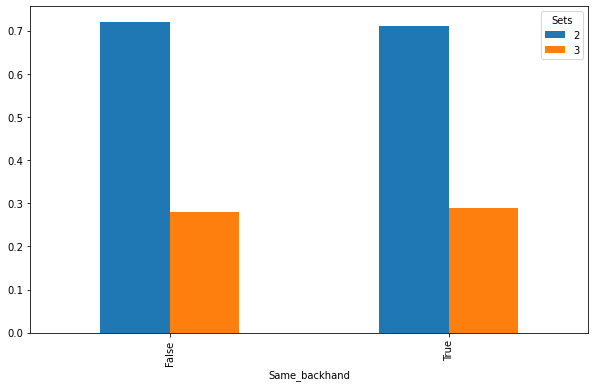

In [61]:
# Same_backhand

cross_tab2 = pd.crosstab(india['Same_backhand'], [india['Sets']])
crosstab_pct2 = cross_tab2.apply(lambda r: r/r.sum(), axis=1)
crosstab_pct2 = crosstab_pct2.apply(lambda r: round(r, 2), axis=0)
crosstab_pct2.plot.bar(figsize=(10,6))

<AxesSubplot:xlabel='India'>

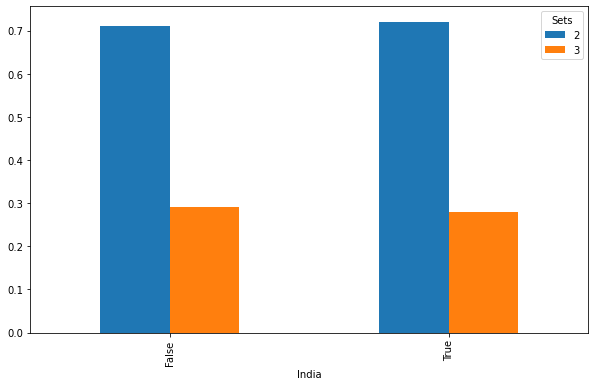

In [62]:
# India

cross_tab4 = pd.crosstab(india['India'], [india['Sets']])
crosstab_pct4 = cross_tab4.apply(lambda r: r/r.sum(), axis=1)
crosstab_pct4 = crosstab_pct4.apply(lambda r: round(r, 2), axis=0)
crosstab_pct4.plot.bar(figsize=(10,6))

In [63]:
crosstab_pct4

Sets,2,3
India,,
False,0.71,0.29
True,0.72,0.28


<AxesSubplot:xlabel='Same_Country'>

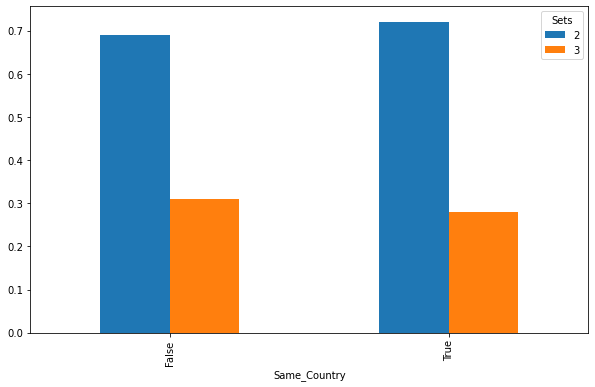

In [64]:
# Same_country

cross_tab3 = pd.crosstab(india['Same_Country'], [india['Sets']])
crosstab_pct3 = cross_tab3.apply(lambda r: r/r.sum(), axis=1)
crosstab_pct3 = crosstab_pct3.apply(lambda r: round(r, 2), axis=0)
crosstab_pct3.plot.bar(figsize=(10,6))

In [59]:
### Seleção das variaveis candidatas aos modelos e continuação de analises

india_candidatas = india.drop(['PlayerName', 'Oponent', 'Height_x', 'Height_y', 'Tournament', 'Ground', 'GameRank_x', 'GameRank_y','Data_inicio','Data_final','Intervalo_Prize', 'Forehand_x','Forehand_y','Backhand_x','Backhand_y','vantagem_playername','vantagem_oponent'], axis=1)

In [60]:
## Criando dummies
# coluna India

india_candidatas['India'] = pd.get_dummies(india_candidatas['India'])[True]

In [61]:
# coluna duracao (depois do modelo)

india_candidatas['Duração'] = pd.get_dummies(india_candidatas['Duração'])[13]

In [62]:
# coluna same_forehand

india_candidatas['Same_forehand'] = pd.get_dummies(india_candidatas['Same_forehand'])[True]

In [63]:
# coluna same_backhand

india_candidatas['Same_backhand'] = pd.get_dummies(india_candidatas['Same_backhand'])[True]

In [64]:
# coluna GameRound

india_candidatas['GameRound'] = np.where(india_candidatas['GameRound'].isin(['3rd Round Qualifying','Semi-Finals', 'Quarter-Finals', 'Finals']), 1, 0)

In [65]:
# coluna Sets

india_candidatas['Sets'] = pd.get_dummies(india_candidatas['Sets'])[3]

In [66]:
# coluna Same_country

india_candidatas['Same_Country'] = pd.get_dummies(india_candidatas['Same_Country'])[True]

In [70]:
# coluna vantagem (depois do modelo)

india_candidatas['vantagem'] = pd.get_dummies(india_candidatas['vantagem'])[True]

KeyError: True

In [69]:
# coluna equilibrio (depois do modelo)

india_candidatas['equilibrio'] = pd.get_dummies(india_candidatas['equilibrio'])[True]

In [71]:
# reodernar colunas do dataframe

india_candidatas = india_candidatas.reindex(columns=['Sets', 'GameRound','Same_forehand','Same_backhand','Same_Country','India','vantagem','equilibrio','Duração','Rank_diff','Height_diff','Prize'])

In [72]:
## Correlaçoes
# variavel alvo com numericas (ANOVA)

import scipy.stats as stats

variavel_alvo = india_candidatas['Sets']

fvalue, pvalue = stats.f_oneway(variavel_alvo, india_candidatas['Rank_diff'])
print('Estatística F (Sets com Rank_diff):', fvalue)
print('Valor de p (Sets com Rank_diff):', pvalue)

fvalue_1, pvalue_1 = stats.f_oneway(variavel_alvo, india_candidatas['Height_diff'])
print('Estatística F (Sets com Height_diff):', fvalue_1)
print('Valor de p (Sets com Height_diff):', pvalue_1)

fvalue_2, pvalue_2 = stats.f_oneway(variavel_alvo, india_candidatas['Prize'])
print('Estatística F (Sets com Prize):', fvalue_2)
print('Valor de p (Sets com Prize):', pvalue_2)

Estatística F (Sets com Rank_diff): 9791.317593003285
Valor de p (Sets com Rank_diff): 0.0
Estatística F (Sets com Height_diff): 1218.138839013609
Valor de p (Sets com Height_diff): 3.4832884450971225e-258
Estatística F (Sets com Prize): 2683.8338639982094
Valor de p (Sets com Prize): 0.0


In [73]:
# variavel alvo com categoricas (qui Quadrado)

variaveis_categoricas = ["GameRound", "Same_forehand", "Same_backhand", "Same_Country", "India","Duração","vantagem", "equilibrio"]

contingency_table = pd.crosstab(india_candidatas['Sets'], [india_candidatas['vantagem']])
chi2, p_value, _, _ = stats.chi2_contingency(contingency_table)
print('Estatística qui-quadrado:', chi2)
print('Valor de p:', p_value)

Estatística qui-quadrado: 0.2076144597295243
Valor de p: 0.6486436258242176


,Rank_diff,Height_diff,Prize
Rank_diff,1.000000,-0.008657,-0.210156
Height_diff,-0.008657,1.000000,0.008659
Prize,-0.210156,0.008659,1.000000


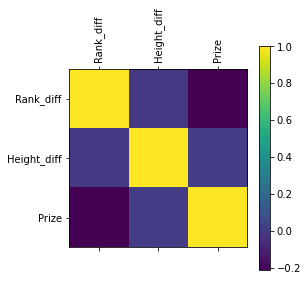

In [74]:
# variaveis numericas com numericas
# matriz de correlacao

variaveis_numericas = india_candidatas.drop(['Sets','GameRound','Same_forehand','Same_backhand','Same_Country','India',"Duração","vantagem", "equilibrio"], axis=1)
matriz = variaveis_numericas.corr()
plt.matshow(matriz)
plt.xticks(range(len(matriz.columns)), matriz.columns, rotation=90)
plt.yticks(range(len(matriz.columns)), matriz.columns)
plt.colorbar()
matriz

In [81]:
india_candidatas.head()

,Sets,GameRound,Same_forehand,Same_backhand,Same_Country,India,vantagem,equilibrio,Duração,Rank_diff,Height_diff,Prize
5,1,1,1,0,0,0,0,0,0,3,23,447480
10,0,1,1,1,0,0,0,0,0,18,15,447480
15,0,0,1,1,0,0,0,0,0,35,18,447480
20,0,0,0,1,0,0,0,0,0,17,15,447480
30,1,1,0,1,1,0,0,1,0,15,6,411000


In [75]:
#### modelos #### 

from sklearn import model_selection, preprocessing, feature_selection, ensemble, linear_model, metrics, decomposition
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve, train_test_split
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

In [76]:
# dividindo o data set em dados de treino e de teste

india_treino, india_teste = model_selection.train_test_split(india_candidatas, test_size = 0.2, random_state = 2)

In [77]:
# Verificando se os dados de treino e teste estao com a mesma proporção de jogos com 2 e 3 sets

india_treino["Sets"].value_counts()/india_treino.shape[0]

0    0.716117
1    0.283883
Name: Sets, dtype: float64

In [78]:
india_teste["Sets"].value_counts()/india_teste.shape[0]  
# proporção parececida

0    0.712676
1    0.287324
Name: Sets, dtype: float64

In [79]:
print(india_treino.shape)
print(india_teste.shape)

(7098, 12)
(1775, 12)


In [80]:
# definindo os dados de entrada e saida (quais serao os preditores e a variavel alvo)

entrada = ["GameRound", "Same_forehand", "Same_backhand", "Same_Country", "India", "Rank_diff", "Height_diff", "Prize", "Duração","vantagem", "equilibrio"]
saida = ["Sets"]

X_treino = india_treino[entrada].values
Y_treino = india_treino[saida].values

X_teste = india_teste[entrada].values
Y_teste = india_teste[saida].values


In [78]:
## Regressao Logistica 

lr = LogisticRegression()

In [79]:
# treinando o modelo 

lr.fit(X_treino, Y_treino)

LogisticRegression()

In [80]:
# fazendo as previsoes 

pred = lr.predict(X_teste)  

In [1630]:
# Avaliação do modelo - regressao logistica

In [1631]:
# Accuracy 

accuracy = metrics.accuracy_score(Y_teste, pred)
print(round(accuracy, 3))

0.713


In [1632]:
# AUC 

auc = metrics.roc_auc_score(Y_teste, pred)
print(round(auc, 3))

0.5


In [1633]:
# Recall

recall = metrics.recall_score(Y_teste, pred)
print(round(recall, 3))

0.0


In [1634]:
# Precision

precision = metrics.precision_score(Y_teste, pred)
print(round(precision, 3))

0.0


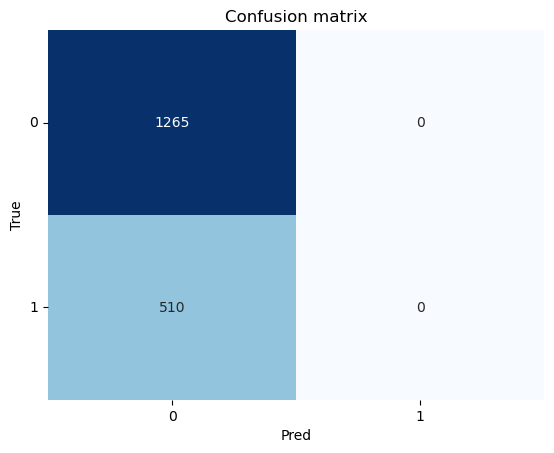

In [1635]:
# matriz de confusao - regressao logistica

classes = np.unique(Y_teste)
fig, ax = plt.subplots()
cm = metrics.confusion_matrix(Y_teste, pred, labels=classes)
sns.heatmap(cm, annot=True, fmt='d', cmap=plt.cm.Blues, cbar=False)
ax.set(xlabel="Pred", ylabel="True", title="Confusion matrix")
ax.set_yticklabels(labels=classes, rotation=0)
plt.show()

In [1636]:
# arvore de decisao

In [149]:
# modelo

tree = DecisionTreeClassifier(random_state=42)

In [150]:
# treinando o modelo

tree.fit(X_treino, Y_treino)

DecisionTreeClassifier(random_state=42)

In [151]:
# fazendo as previsoes

pred_1 = tree.predict(X_teste)


In [163]:
pred_prob = (tree.predict_proba(X_teste)[:,1] >= 20).astype(int)

In [153]:
# Avaliacao do modelo - arvore de decisao

# Accuracy 

accuracy = metrics.accuracy_score(Y_teste, pred_1)
print(round(accuracy, 3))

0.592


In [159]:
# AUC 

auc = metrics.roc_auc_score(Y_teste, pred_1)
print(round(auc, 3))

0.508


In [158]:
# Recall

recall = metrics.recall_score(Y_teste, pred_1)
print(round(recall, 3))

0.31


In [91]:
# Precision

precision = metrics.precision_score(Y_teste, pred_1)
print(round(precision, 3))

0.306


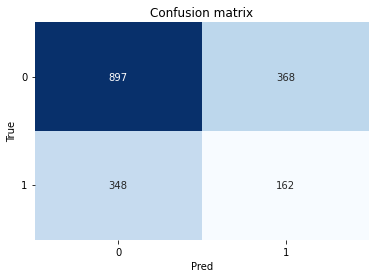

In [92]:
# matriz de confusao - arvore de decisao

classes = np.unique(Y_teste)
fig, ax = plt.subplots()
cm = metrics.confusion_matrix(Y_teste, pred_1, labels=classes)
sns.heatmap(cm, annot=True, fmt='d', cmap=plt.cm.Blues, cbar=False)
ax.set(xlabel="Pred", ylabel="True", title="Confusion matrix")
ax.set_yticklabels(labels=classes, rotation=0)
plt.show()

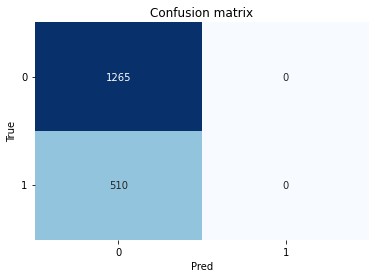

In [164]:
classes = np.unique(Y_teste)
fig, ax = plt.subplots()
cm = metrics.confusion_matrix(Y_teste, pred_prob, labels=classes)
sns.heatmap(cm, annot=True, fmt='d', cmap=plt.cm.Blues, cbar=False)
ax.set(xlabel="Pred", ylabel="True", title="Confusion matrix")
ax.set_yticklabels(labels=classes, rotation=0)
plt.show()

In [ ]:
# mostrando a curva ROC 


In [1645]:
# arvore de decisao com K cross validation

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

k = 10
kf = KFold(n_splits=k, shuffle=True, random_state=42)

In [1675]:
scores = cross_val_score(tree, india_candidatas[entrada].values, india_candidatas[saida].values, cv=kf, scoring='accuracy')
print('Pontuações de desempenho:', scores)
print('Média das pontuações de desempenho:', scores.mean())

Pontuações de desempenho: [0.60247748 0.60923423 0.58896396 0.59413754 0.60202931 0.6065389
 0.59977452 0.60879369 0.62683202 0.59864713]
Média das pontuações de desempenho: 0.6037428776013893


In [1678]:
scores = cross_val_score(tree, india_candidatas[entrada].values, india_candidatas[saida].values, cv=kf, scoring='f1')
print('Pontuações de desempenho:', scores)
print('Média das pontuações de desempenho:', scores.mean())

Pontuações de desempenho: [0.33017078 0.33904762 0.28290766 0.296875   0.29540918 0.28336756
 0.25887265 0.31558185 0.33667335 0.29365079]
Média das pontuações de desempenho: 0.3032556442968214


In [1679]:
scores = cross_val_score(tree, india_candidatas[entrada].values, india_candidatas[saida].values, cv=kf, scoring='precision')
print('Pontuações de desempenho:', scores)
print('Média das pontuações de desempenho:', scores.mean())

Pontuações de desempenho: [0.33333333 0.32363636 0.26373626 0.30522088 0.30327869 0.2875
 0.27192982 0.31007752 0.33870968 0.29718876]
Média das pontuações de desempenho: 0.30346113091453714


In [1680]:
scores = cross_val_score(tree, india_candidatas[entrada].values, india_candidatas[saida].values, cv=kf, scoring='recall')
print('Pontuações de desempenho:', scores)
print('Média das pontuações de desempenho:', scores.mean())

Pontuações de desempenho: [0.32706767 0.356      0.30508475 0.28897338 0.28793774 0.27935223
 0.24701195 0.32128514 0.33466135 0.29019608]
Média das pontuações de desempenho: 0.30375702946439015


In [1648]:
# modelo svm

In [1649]:
# modelo

svc = SVC()

In [1650]:
# treinando o modelo

svc.fit(X_treino, Y_treino)

SVC()

In [1651]:
# fazendo as previsoes

pred_2 = svc.predict(X_teste)

In [1652]:
# Avaliacao do modelo - svm

# Accuracy 

accuracy = metrics.accuracy_score(Y_teste, pred_2)
print(round(accuracy, 3))

0.713


In [1653]:
# AUC 

auc = metrics.roc_auc_score(Y_teste, pred_2)
print(round(auc, 3))

0.5


In [1654]:
# Recall

recall = metrics.recall_score(Y_teste, pred_2)
print(round(recall, 3))

0.0


In [1655]:
# Precision

precision = metrics.precision_score(Y_teste, pred_2)
print(round(precision, 3))

0.0


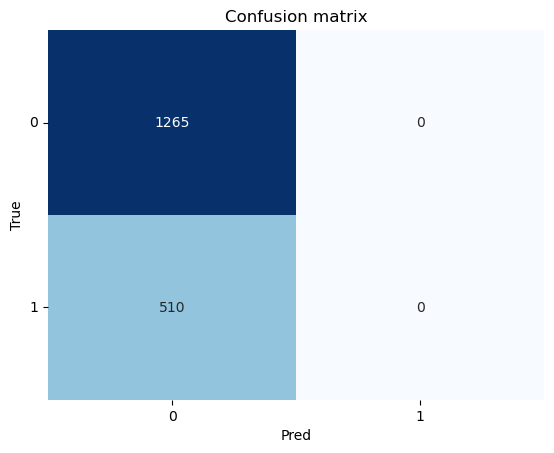

In [1656]:
# matriz de confusao - svm

classes = np.unique(Y_teste)
fig, ax = plt.subplots()
cm = metrics.confusion_matrix(Y_teste, pred_2, labels=classes)
sns.heatmap(cm, annot=True, fmt='d', cmap=plt.cm.Blues, cbar=False)
ax.set(xlabel="Pred", ylabel="True", title="Confusion matrix")
ax.set_yticklabels(labels=classes, rotation=0)
plt.show()

In [ ]:
# random forest 


In [100]:
from sklearn.ensemble import RandomForestClassifier


In [106]:
rf2 = RandomForestClassifier(max_depth=2, random_state = 42)
rf2.fit(X_treino, Y_treino)

RandomForestClassifier(max_depth=2, random_state=42)

In [110]:
pred_rf = rf2.predict(X_teste)

In [112]:
# Accuracy 

acc_rf = metrics.accuracy_score(Y_teste, pred_rf)
acc_rf

0.7126760563380282

In [114]:
# Precision 

preci_rf = metrics.precision_score(Y_teste, pred_rf)
preci_rf

0.0

<BarContainer object of 11 artists>

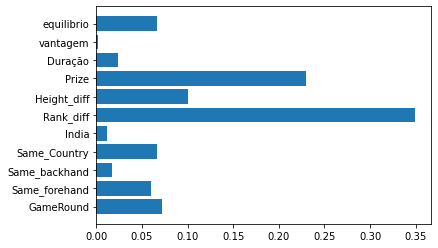

In [108]:
# importancia das variaveis para o Random Forest 

feature_names = ["GameRound", "Same_forehand", "Same_backhand", "Same_Country", "India", "Rank_diff", "Height_diff", "Prize", "Duração","vantagem", "equilibrio"]
plt.barh(feature_names, rf2.feature_importances_)

<BarContainer object of 11 artists>

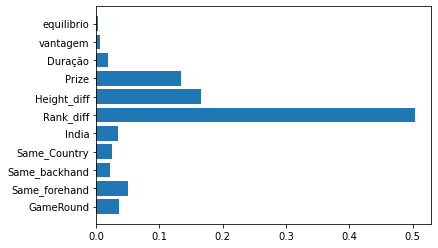

In [109]:
# Importancia para o decision tree 

feature_names = ["GameRound", "Same_forehand", "Same_backhand", "Same_Country", "India", "Rank_diff", "Height_diff", "Prize", "Duração","vantagem", "equilibrio"]
plt.barh(feature_names, tree.feature_importances_)

In [89]:
# testando outra forma 
# modelo Gradient Boosting 

model = ensemble.GradientBoostingClassifier()

In [90]:
param_dic = {'learning_rate':[0.15,0.1,0.05,0.01,0.005,0.001],   # primeira tentativa com os parametros iniciais   
'n_estimators':[100,250,500,750,1000,1250,1500,1750], 
'min_samples_split':[2,4,6,8,10,20,40,60,100],   
'min_samples_leaf':[1,3,5,7,9],     
'max_features':[2,3,4,5,6,7],     
'subsample':[0.7,0.75,0.8,0.85,0.9,0.95,1]}     

In [107]:
param_dic = {'learning_rate':[0.12,0.08,0.04,0.01,0.0075,0.0030],     # outra tentativa 
'n_estimators':[150,350,650,1000,1250,1500,1750,2000], 
'min_samples_split':[2,4,6,8,10,20,40,60,100],   
'min_samples_leaf':[1,3,5,7,9],     
'max_features':[3,4,5,6,7,8],     
'subsample':[0.7,0.75,0.8,0.85,0.9,0.95,1]}  

In [108]:
random_search = model_selection.RandomizedSearchCV(model, 
       param_distributions=param_dic, n_iter=20, 
       scoring="precision").fit(X_treino, Y_treino)
print("Best Model parameters:", random_search.best_params_)
print("Best Model mean precision:", random_search.best_score_)

Best Model parameters: {'subsample': 0.75, 'n_estimators': 2000, 'min_samples_split': 4, 'min_samples_leaf': 3, 'max_features': 4, 'learning_rate': 0.003}
Best Model mean precision: 0.5666666666666667


In [109]:
model = random_search.best_estimator_

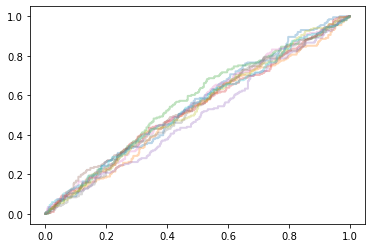

In [110]:
# validação do modelo pelo k cross validation

import scipy

cv = model_selection.StratifiedKFold(n_splits=10, shuffle=True)
tprs, aucs = [], []
mean_fpr = np.linspace(0,1,100)
fig = plt.figure()
i = 1
for train, test in cv.split(X_treino, Y_treino):
    prediction = model.fit(X_treino[train], Y_treino[train]).predict_proba(X_treino[test])
    fpr, tpr, t = metrics.roc_curve(Y_treino[test], prediction[:, 1])
    tprs.append(scipy.interp(mean_fpr, fpr, tpr))
    roc_auc = metrics.auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=2, alpha=0.3, label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))
    i = i+1

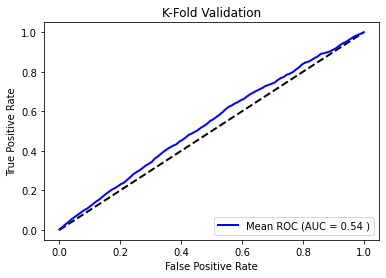

In [111]:
plt.plot([0,1], [0,1], linestyle='--', lw=2, color='black')
mean_tpr = np.mean(tprs, axis=0)
mean_auc = metrics.auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, color='blue', label=r'Mean ROC (AUC = %0.2f )' % (mean_auc), lw=2, alpha=1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('K-Fold Validation')
plt.legend(loc="lower right")
plt.show()

In [112]:
# treinando o melhor modelo escolhido 

model.fit(X_treino, Y_treino)


GradientBoostingClassifier(learning_rate=0.003, max_features=4,
                           min_samples_leaf=3, min_samples_split=4,
                           n_estimators=2000, subsample=0.75)

In [113]:
previsao = model.predict(X_teste)


In [114]:
previsao_prob = model.predict_proba(X_teste)[:,1]

In [ ]:
# Evaluation #

In [115]:
# Accuracy 

acc = metrics.accuracy_score(Y_teste, previsao)
acc

0.712112676056338

In [116]:
# AUC

auc = metrics.roc_auc_score(Y_teste, previsao_prob)
auc

0.5432612570719988

In [117]:
# recall 

recall = metrics.recall_score(Y_teste, previsao)
recall

0.0

In [118]:
# Precision 

precision = metrics.precision_score(Y_teste, previsao)
precision

0.0

<BarContainer object of 11 artists>

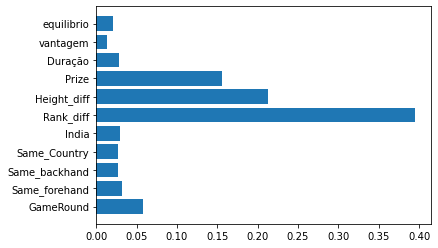

In [119]:
feature_names = ["GameRound", "Same_forehand", "Same_backhand", "Same_Country", "India", "Rank_diff", "Height_diff", "Prize", "Duração","vantagem", "equilibrio"]
plt.barh(feature_names, model.feature_importances_)

In [120]:
# tentando sem a vantagem e o equilibrio 

entrada = ["GameRound", "Same_forehand", "Same_backhand", "Same_Country", "India", "Rank_diff", "Height_diff", "Prize", "Duração"]
saida = ["Sets"]

X_treino = india_treino[entrada].values
Y_treino = india_treino[saida].values

X_teste = india_teste[entrada].values
Y_teste = india_teste[saida].values

In [121]:
param_dic = {'learning_rate':[0.15,0.1,0.05,0.01,0.005,0.001],   # primeira tentativa com os parametros iniciais   
'n_estimators':[100,250,500,750,1000,1250,1500,1750], 
'min_samples_split':[2,4,6,8,10,20,40,60,100],   
'min_samples_leaf':[1,3,5,7,9],     
'max_features':[2,3,4,5,6,7],     
'subsample':[0.7,0.75,0.8,0.85,0.9,0.95,1]}  


random_search = model_selection.RandomizedSearchCV(model, 
       param_distributions=param_dic, n_iter=20, 
       scoring="precision").fit(X_treino, Y_treino)
print("Best Model parameters:", random_search.best_params_)
print("Best Model mean precision:", random_search.best_score_)



Best Model parameters: {'subsample': 0.9, 'n_estimators': 1250, 'min_samples_split': 2, 'min_samples_leaf': 7, 'max_features': 3, 'learning_rate': 0.005}
Best Model mean precision: 0.6


In [122]:
model = random_search.best_estimator_

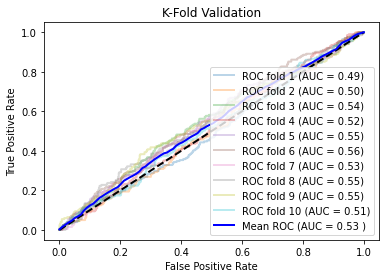

In [123]:
import scipy

cv = model_selection.StratifiedKFold(n_splits=10, shuffle=True)
tprs, aucs = [], []
mean_fpr = np.linspace(0,1,100)
fig = plt.figure()
i = 1
for train, test in cv.split(X_treino, Y_treino):
    prediction = model.fit(X_treino[train], Y_treino[train]).predict_proba(X_treino[test])
    fpr, tpr, t = metrics.roc_curve(Y_treino[test], prediction[:, 1])
    tprs.append(scipy.interp(mean_fpr, fpr, tpr))
    roc_auc = metrics.auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=2, alpha=0.3, label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))
    i = i+1
    
    

    
    
plt.plot([0,1], [0,1], linestyle='--', lw=2, color='black')
mean_tpr = np.mean(tprs, axis=0)
mean_auc = metrics.auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, color='blue', label=r'Mean ROC (AUC = %0.2f )' % (mean_auc), lw=2, alpha=1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('K-Fold Validation')
plt.legend(loc="lower right")
plt.show()    


In [124]:
model.fit(X_treino, Y_treino)
previsao = model.predict(X_teste)
previsao_prob = model.predict_proba(X_teste)[:,1]

In [125]:
recall = metrics.recall_score(Y_teste, previsao)
recall


0.00196078431372549

In [126]:
precision = metrics.precision_score(Y_teste, previsao)
precision


0.5

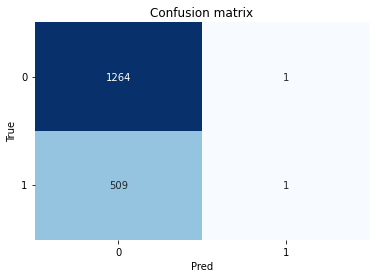

In [127]:
classes = np.unique(Y_teste)
fig, ax = plt.subplots()
cm = metrics.confusion_matrix(Y_teste, previsao, labels=classes)
sns.heatmap(cm, annot=True, fmt='d', cmap=plt.cm.Blues, cbar=False)
ax.set(xlabel="Pred", ylabel="True", title="Confusion matrix")
ax.set_yticklabels(labels=classes, rotation=0)
plt.show()

In [139]:
# mudando o limite 
model.fit(X_treino, Y_treino)
predicted_prob1 = (model.predict_proba(X_teste)[:,1] >= 0.30).astype(int) 
predicted1 = model.predict(X_teste)

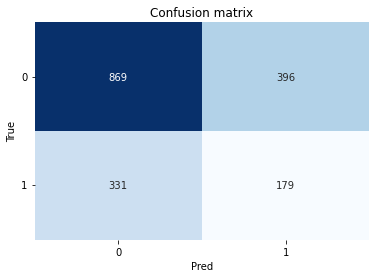

In [140]:
classes = np.unique(Y_teste)
fig, ax = plt.subplots()
cm = metrics.confusion_matrix(Y_teste, predicted_prob1, labels=classes)
sns.heatmap(cm, annot=True, fmt='d', cmap=plt.cm.Blues, cbar=False)
ax.set(xlabel="Pred", ylabel="True", title="Confusion matrix")
ax.set_yticklabels(labels=classes, rotation=0)
plt.show()

In [143]:
# AUC 
auc = metrics.roc_auc_score(Y_teste, predicted_prob1)
auc

0.5189684569479966

In [144]:
# precision 
p = metrics.precision_score(Y_teste, predicted_prob1)
p

0.31130434782608696

In [145]:
recall = metrics.recall_score(Y_teste, predicted_prob1)
recall

0.3509803921568627

In [146]:
acc = metrics.accuracy_score(Y_teste, predicted_prob1)
acc

0.5904225352112676

<BarContainer object of 9 artists>

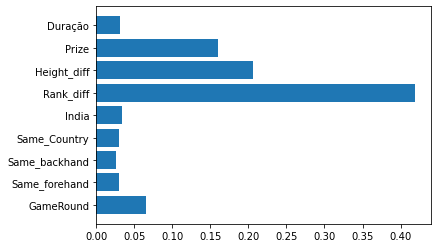

In [147]:
feature_names = ["GameRound", "Same_forehand", "Same_backhand", "Same_Country", "India", "Rank_diff", "Height_diff", "Prize", "Duração"]
plt.barh(feature_names, model.feature_importances_)

In [240]:
# tentando somente com as 5 variaveis mais importantes - melhor modelo ate agora (com limite de 0.3)

entrada = ["GameRound", "Rank_diff", "Height_diff", "Prize", "Duração"]
saida = ["Sets"]

X_treino = india_treino[entrada].values
Y_treino = india_treino[saida].values

X_teste = india_teste[entrada].values
Y_teste = india_teste[saida].values

In [241]:
model = ensemble.GradientBoostingClassifier()

In [242]:
param_dic = {'learning_rate':[0.15,0.1,0.05,0.01,0.005,0.001],    
'n_estimators':[200,400,800,1000,1300,1600,2000,2500], 
'min_samples_split':[2,4,6,8,10,20,40,60,100],   
'min_samples_leaf':[1,3,5,7,9],     
'max_features':[2,3,4,5,5,5],     
'subsample':[0.7,0.75,0.8,0.85,0.9,0.95,1]}  


random_search = model_selection.RandomizedSearchCV(model, 
       param_distributions=param_dic, n_iter=25, 
       scoring="f1").fit(X_treino, Y_treino)
print("Best Model parameters:", random_search.best_params_)
print("Best Model mean f1:", random_search.best_score_)

Best Model parameters: {'subsample': 0.85, 'n_estimators': 2000, 'min_samples_split': 60, 'min_samples_leaf': 9, 'max_features': 5, 'learning_rate': 0.15}
Best Model mean f1: 0.18267532638341608


In [243]:
model = random_search.best_estimator_

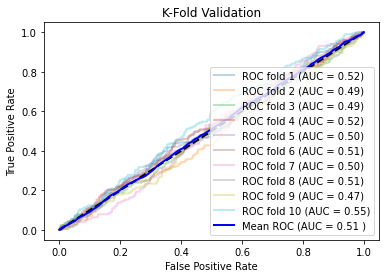

In [244]:
import scipy

cv = model_selection.StratifiedKFold(n_splits=10, shuffle=True)
tprs, aucs = [], []
mean_fpr = np.linspace(0,1,100)
fig = plt.figure()
i = 1
for train, test in cv.split(X_treino, Y_treino):
    prediction = model.fit(X_treino[train], Y_treino[train]).predict_proba(X_treino[test])
    fpr, tpr, t = metrics.roc_curve(Y_treino[test], prediction[:, 1])
    tprs.append(scipy.interp(mean_fpr, fpr, tpr))
    roc_auc = metrics.auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=2, alpha=0.3, label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))
    i = i+1
    
    

    
    
plt.plot([0,1], [0,1], linestyle='--', lw=2, color='black')
mean_tpr = np.mean(tprs, axis=0)
mean_auc = metrics.auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, color='blue', label=r'Mean ROC (AUC = %0.2f )' % (mean_auc), lw=2, alpha=1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('K-Fold Validation')
plt.legend(loc="lower right")
plt.show()    

In [245]:
model.fit(X_treino, Y_treino)
previsao = model.predict(X_teste)
previsao_prob = model.predict_proba(X_teste)[:,1]

In [246]:
recall = metrics.recall_score(Y_teste, previsao)
recall

0.10588235294117647

In [247]:
precision = metrics.precision_score(Y_teste, previsao)
precision

0.271356783919598

In [250]:
# mudando o limite da probabilidade (melhores resultados)
model.fit(X_treino, Y_treino)
predicted_prob1 = (model.predict_proba(X_teste)[:,1] >= 0.30).astype(int) # set threshold as 0.35
predicted1 = model.predict(X_teste)

In [251]:
# AUC 
auc = metrics.roc_auc_score(Y_teste, predicted_prob1)
auc

0.5035418119817097

In [252]:
# precision 
p = metrics.precision_score(Y_teste, predicted_prob1)
p

0.2909604519774011

In [253]:
recall = metrics.recall_score(Y_teste, predicted_prob1)
recall

0.403921568627451

In [254]:
acc = metrics.accuracy_score(Y_teste, predicted_prob1)
acc

0.5459154929577464

<BarContainer object of 5 artists>

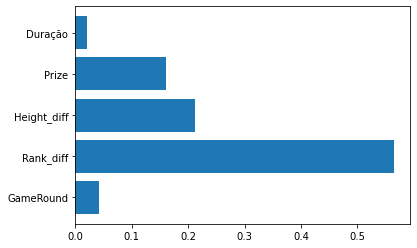

In [232]:
feature_names = ["GameRound", "Rank_diff", "Height_diff", "Prize", "Duração"]
plt.barh(feature_names, model.feature_importances_)

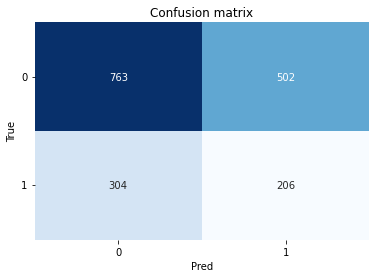

In [255]:
# matriz de confusao 

classes = np.unique(Y_teste)
fig, ax = plt.subplots()
cm = metrics.confusion_matrix(Y_teste, predicted_prob1, labels=classes)
sns.heatmap(cm, annot=True, fmt='d', cmap=plt.cm.Blues, cbar=False)
ax.set(xlabel="Pred", ylabel="True", title="Confusion matrix")
ax.set_yticklabels(labels=classes, rotation=0)
plt.show()

In [ ]:
# testando novamente, mudandando alguns paramentros 

In [190]:
model = ensemble.GradientBoostingClassifier()

In [191]:
param_dic = {'learning_rate':[0.15,0.1,0.05,0.01,0.005,0.001],    
'n_estimators':[200,400,800,1000,1300,1600,2000,2500], 
'min_samples_split':[2,4,6,8,10,20,40,60,100],   
'min_samples_leaf':[1,3,5,7,9],     
'max_features':[2,3,4,5,5,5],     
'subsample':[0.7,0.75,0.8,0.85,0.9,0.95,1]}  


random_search = model_selection.RandomizedSearchCV(model, 
       param_distributions=param_dic, n_iter=20, 
       scoring="precision").fit(X_treino, Y_treino)
print("Best Model parameters:", random_search.best_params_)
print("Best Model mean precision:", random_search.best_score_)

Best Model parameters: {'subsample': 0.95, 'n_estimators': 1300, 'min_samples_split': 2, 'min_samples_leaf': 9, 'max_features': 3, 'learning_rate': 0.005}
Best Model mean precision: 0.35


In [192]:
model = random_search.best_estimator_

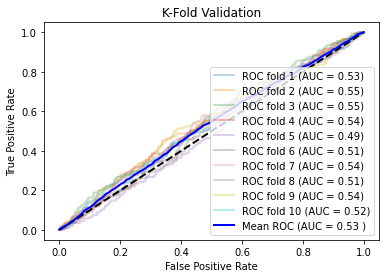

In [193]:
import scipy

cv = model_selection.StratifiedKFold(n_splits=10, shuffle=True)
tprs, aucs = [], []
mean_fpr = np.linspace(0,1,100)
fig = plt.figure()
i = 1
for train, test in cv.split(X_treino, Y_treino):
    prediction = model.fit(X_treino[train], Y_treino[train]).predict_proba(X_treino[test])
    fpr, tpr, t = metrics.roc_curve(Y_treino[test], prediction[:, 1])
    tprs.append(scipy.interp(mean_fpr, fpr, tpr))
    roc_auc = metrics.auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=2, alpha=0.3, label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))
    i = i+1
    
    

    
    
plt.plot([0,1], [0,1], linestyle='--', lw=2, color='black')
mean_tpr = np.mean(tprs, axis=0)
mean_auc = metrics.auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, color='blue', label=r'Mean ROC (AUC = %0.2f )' % (mean_auc), lw=2, alpha=1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('K-Fold Validation')
plt.legend(loc="lower right")
plt.show()    

In [194]:
model.fit(X_treino, Y_treino)
predicted_prob1 = (model.predict_proba(X_teste)[:,1] >= 0.30).astype(int) # set threshold as 0.35
predicted1 = model.predict(X_teste)

In [195]:
# AUC 
auc = metrics.roc_auc_score(Y_teste, predicted_prob1)
auc

0.5248198093466636

In [196]:
# precision 
p = metrics.precision_score(Y_teste, predicted_prob1)
p

0.3176470588235294

In [197]:
recall = metrics.recall_score(Y_teste, predicted_prob1)
recall

0.37058823529411766

In [ ]:
# testando de novo, mudando os parametros novamente, abaixando o numero de estimadores agora 

In [199]:
entrada = ["GameRound", "Rank_diff", "Height_diff", "Prize", "Duração"]
saida = ["Sets"]

X_treino = india_treino[entrada].values
Y_treino = india_treino[saida].values

X_teste = india_teste[entrada].values
Y_teste = india_teste[saida].values

In [200]:
model = ensemble.GradientBoostingClassifier()

In [201]:
param_dic = {'learning_rate':[0.15,0.1,0.05,0.01,0.005,0.001],    
'n_estimators':[70,120,200,400,600,850,1000,1250], 
'min_samples_split':[2,4,6,8,10,20,40,60,100],   
'min_samples_leaf':[1,3,5,7,9],     
'max_features':[2,3,4,5,5,5],     
'subsample':[0.7,0.75,0.8,0.85,0.9,0.95,1]}  


random_search = model_selection.RandomizedSearchCV(model, 
       param_distributions=param_dic, n_iter=20, 
       scoring="precision").fit(X_treino, Y_treino)
print("Best Model parameters:", random_search.best_params_)
print("Best Model mean precision:", random_search.best_score_)

Best Model parameters: {'subsample': 0.8, 'n_estimators': 120, 'min_samples_split': 40, 'min_samples_leaf': 3, 'max_features': 2, 'learning_rate': 0.05}
Best Model mean precision: 0.42857142857142855


In [202]:
model = random_search.best_estimator_

In [203]:
model.fit(X_treino, Y_treino)
predicted_prob1 = (model.predict_proba(X_teste)[:,1] >= 0.30).astype(int) # set threshold as 0.35
predicted1 = model.predict(X_teste)

In [204]:
# AUC 
auc = metrics.roc_auc_score(Y_teste, predicted_prob1)
auc

0.5338177168100442

In [205]:
# precision 
p = metrics.precision_score(Y_teste, predicted_prob1)
p

0.3273615635179153

In [206]:
recall = metrics.recall_score(Y_teste, predicted_prob1)
recall

0.3941176470588235

In [208]:
acc = metrics.accuracy_score(Y_teste, predicted_prob1)
acc

0.5932394366197183

In [ ]:
# tentando com as 5 variaveis, com treshold de 0.3 e melhor scoring = recall


In [179]:
entrada = ["GameRound", "Rank_diff", "Height_diff", "Prize", "Duração"]
saida = ["Sets"]

X_treino = india_treino[entrada].values
Y_treino = india_treino[saida].values

X_teste = india_teste[entrada].values
Y_teste = india_teste[saida].values

In [180]:
model = ensemble.GradientBoostingClassifier()

In [181]:
param_dic = {'learning_rate':[0.15,0.1,0.05,0.01,0.005,0.001],    
'n_estimators':[100,250,500,750,1000,1250,1500,1750], 
'min_samples_split':[2,4,6,8,10,20,40,60,100],   
'min_samples_leaf':[1,3,5,7,9],     
'max_features':[1,2,3,4,5],     
'subsample':[0.7,0.75,0.8,0.85,0.9,0.95,1]}  


random_search = model_selection.RandomizedSearchCV(model, 
       param_distributions=param_dic, n_iter=20, 
       scoring="recall").fit(X_treino, Y_treino)
print("Best Model parameters:", random_search.best_params_)
print("Best Model mean precision:", random_search.best_score_)

Best Model parameters: {'subsample': 0.8, 'n_estimators': 1750, 'min_samples_split': 8, 'min_samples_leaf': 7, 'max_features': 5, 'learning_rate': 0.1}
Best Model mean precision: 0.12109181141439204


In [182]:
model = random_search.best_estimator_

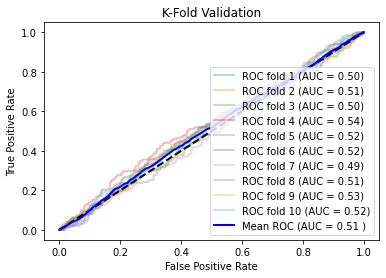

In [183]:
import scipy

cv = model_selection.StratifiedKFold(n_splits=10, shuffle=True)
tprs, aucs = [], []
mean_fpr = np.linspace(0,1,100)
fig = plt.figure()
i = 1
for train, test in cv.split(X_treino, Y_treino):
    prediction = model.fit(X_treino[train], Y_treino[train]).predict_proba(X_treino[test])
    fpr, tpr, t = metrics.roc_curve(Y_treino[test], prediction[:, 1])
    tprs.append(scipy.interp(mean_fpr, fpr, tpr))
    roc_auc = metrics.auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=2, alpha=0.3, label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))
    i = i+1
    
    
    
    
plt.plot([0,1], [0,1], linestyle='--', lw=2, color='black')
mean_tpr = np.mean(tprs, axis=0)
mean_auc = metrics.auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, color='blue', label=r'Mean ROC (AUC = %0.2f )' % (mean_auc), lw=2, alpha=1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('K-Fold Validation')
plt.legend(loc="lower right")
plt.show() 

In [184]:
model.fit(X_treino, Y_treino)
predicted_prob1 = (model.predict_proba(X_teste)[:,1] >= 0.30).astype(int) # set threshold as 0.35
predicted1 = model.predict(X_teste)

In [185]:
# AUC 
auc = metrics.roc_auc_score(Y_teste, predicted_prob1)
auc

0.5102456792993877

In [186]:
# precision 
p = metrics.precision_score(Y_teste, predicted_prob1)
p

0.2979942693409742

In [187]:
recall = metrics.recall_score(Y_teste, predicted_prob1)
recall

0.40784313725490196

In [188]:
acc = metrics.accuracy_score(Y_teste, predicted_prob1)
acc

0.5538028169014084

In [ ]:
# fazendo com todas as variaveis, com o scoring = precision , limite de 0.3 e com alguns parametros diferentes

In [273]:
entrada = ["GameRound", "Same_forehand", "Same_backhand", "Same_Country", "India", "Rank_diff", "Height_diff", "Prize", "Duração","vantagem", "equilibrio"]
saida = ["Sets"]

X_treino = india_treino[entrada].values
Y_treino = india_treino[saida].values

X_teste = india_teste[entrada].values
Y_teste = india_teste[saida].values


In [274]:
model = ensemble.GradientBoostingClassifier()

In [275]:
param_dic = {'learning_rate':[0.15,0.1,0.05,0.01,0.005,0.001],    
'n_estimators':[100,250,500,750,1250,1500,2000,2500], 
'min_samples_split':[2,4,6,8,10,20,30,45,70],   
'min_samples_leaf':[1,3,5,7,9],     
'max_features':[1,3,5,7,9,11],     
'subsample':[0.65,0.70,0.75,0.8,0.85,0.9,0.95]}  


random_search = model_selection.RandomizedSearchCV(model, 
       param_distributions=param_dic, n_iter=25, 
       scoring="precision").fit(X_treino, Y_treino)
print("Best Model parameters:", random_search.best_params_)
print("Best Model mean precision:", random_search.best_score_)

Best Model parameters: {'subsample': 0.65, 'n_estimators': 100, 'min_samples_split': 70, 'min_samples_leaf': 7, 'max_features': 1, 'learning_rate': 0.15}
Best Model mean precision: 0.62


In [276]:
model = random_search.best_estimator_

In [293]:
model.fit(X_treino, Y_treino)
predicted_prob1 = (model.predict_proba(X_teste)[:,1] >= 0.31).astype(int) 
predicted1 = model.predict(X_teste)

In [294]:
# AUC 

auc = metrics.roc_auc_score(Y_teste, predicted_prob1)
auc

0.5210493683639463

In [295]:
# precision 

p = metrics.precision_score(Y_teste, predicted_prob1)
p

0.3225806451612903

In [296]:
# recall

recall = metrics.recall_score(Y_teste, predicted_prob1)
recall

0.27450980392156865

In [297]:
# accuracy 

acc = metrics.accuracy_score(Y_teste, predicted_prob1)
acc

0.6259154929577465

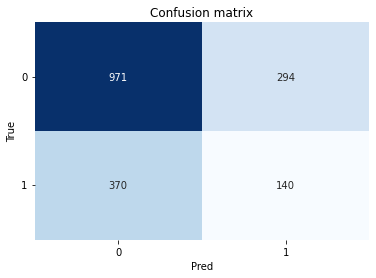

In [298]:
# matriz de confusao 

classes = np.unique(Y_teste)
fig, ax = plt.subplots()
cm = metrics.confusion_matrix(Y_teste, predicted_prob1, labels=classes)
sns.heatmap(cm, annot=True, fmt='d', cmap=plt.cm.Blues, cbar=False)
ax.set(xlabel="Pred", ylabel="True", title="Confusion matrix")
ax.set_yticklabels(labels=classes, rotation=0)
plt.show()